# Title

## 1. Introduction

TBA

## 2. Preliminary Results

### 2.1 R Preamble

In [55]:
# Run this first.
library(tidyverse)
library(tidymodels)

set.seed(5)
options(repr.plot.width = 6, repr.plot.height = 4)

SRC <-
    c("https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/ubc.csv",
      "https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/sfu.csv")

### 2.2 Loading and wrangling the dataset

Note that the raw UBC and SFU datasets span different date ranges. However, our analysis will focus mainly on the min. and max. daily temperatures, which might vary depending on the date. To prevent this from potentially skewing our results, we filter our wrangled dataset such that it spans the intersection of the UBC and SFU date ranges (from January 1 to June 30, 1995).

In [42]:
# Load and label the raw datasets for UBC and SFU, respectively.
ubc_raw <- read_csv(SRC[1], show_col_types = FALSE) |>
    mutate(location = as.factor("UBC"))

sfu_raw <- read_csv(SRC[2], show_col_types = FALSE) |>
    mutate(location = as.factor("SFU"))

# Join the datasets, select the relevant variables, and tidy the data.
ubc_sfu_raw <- bind_rows(ubc_raw, sfu_raw) |>
    rename(date_time = "Date/Time", 
           min_temp_c = "Min Temp (°C)", max_temp_c = "Max Temp (°C)") |>
    select(location, date_time, min_temp_c, max_temp_c) |>
    filter(!is.na(min_temp_c), !is.na(max_temp_c))

# Find the intersection of the date ranges and filter the dataset.
date_range <- ubc_sfu_raw |>
    group_by(location) |>
    summarize(min = min(date_time), max = max(date_time)) |>
    ungroup() |>
    summarize(min = max(min), max = min(max))

ubc_sfu_data <- ubc_sfu_raw |>
    filter(between(date_time, date_range$min, date_range$max))

# Preview the dataset.
cat("Table 1: Cleaned and Filtered Combined Data for UBC and SFU")
head(ubc_sfu_data)
tail(ubc_sfu_data)

Table 1: Cleaned and Filtered Combined Data for UBC and SFU

location,date_time,min_temp_c,max_temp_c
<fct>,<date>,<dbl>,<dbl>
UBC,1995-01-01,-3.5,4.0
UBC,1995-01-02,-3.5,4.0
UBC,1995-01-03,-4.5,4.5
UBC,1995-01-04,-5.0,4.0
UBC,1995-01-05,-4.0,3.0
UBC,1995-01-06,-4.0,3.0


location,date_time,min_temp_c,max_temp_c
<fct>,<date>,<dbl>,<dbl>
SFU,1995-06-25,12,24.0
SFU,1995-06-26,12,22.0
SFU,1995-06-27,16,25.0
SFU,1995-06-28,19,29.0
SFU,1995-06-29,20,29.5
SFU,1995-06-30,21,30.0


### 2.3 Summary statistics

We calculate the summary statistics of interest for both UBC and SFU. We can see that the sample sizes are not equal, but this is not a problem since both asymptotics and bootstrap methods will address this.

In [43]:
# Calculate means, standard deviations, and counts for both locations.
ubc_sfu_summary <- ubc_sfu_data |>
    group_by(location) |>
    summarize(mean_min = mean(min_temp_c), sd_min = sd(min_temp_c),
              mean_max = mean(max_temp_c), sd_max = sd(max_temp_c),
              n = n())

cat("Table 2: Summary Statistics for UBC and SFU")
ubc_sfu_summary

Table 2: Summary Statistics for UBC and SFU

location,mean_min,sd_min,mean_max,sd_max,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
UBC,6.279006,4.821630,13.10773,5.523258,181
SFU,5.770950,4.812559,13.11732,6.357132,179


### 2.4 Preliminary visualization

We begin by plotting the raw data in order to better understand the dataset. Roughly speaking, it appears that the min. and max. daily temperatures for both locations are correlated, as they follow a similar trend over time.

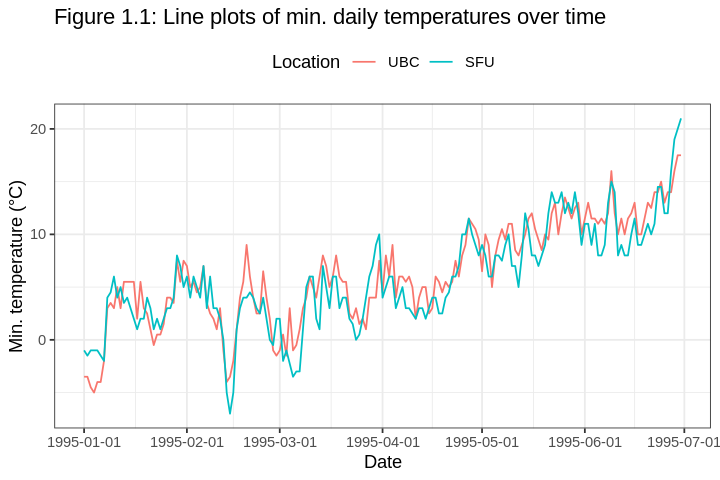

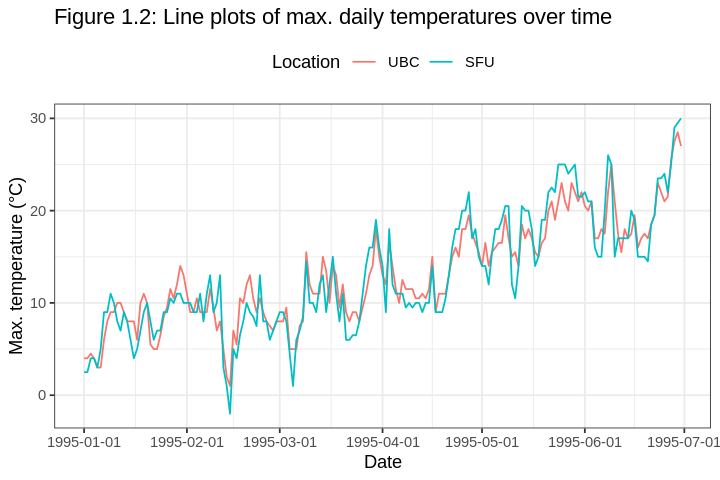

In [44]:
# Visualize min. daily temperatures over time.
ubc_sfu_min_line_plot <- ubc_sfu_data |>
    ggplot(aes(x = date_time, y = min_temp_c, color = location)) +
        geom_line(alpha = 1) +
        labs(title = "Figure 1.1: Line plots of min. daily temperatures over time",
             x = "Date", y = "Min. temperature (°C)", color = "Location") +
        scale_x_date(breaks = "1 month") +
        theme_bw() +
        theme(legend.position = "top")

# Visualize max. daily temperatures over time.
ubc_sfu_max_line_plot <- ubc_sfu_data |>
    ggplot(aes(x = date_time, y = max_temp_c, color = location)) +
        geom_line(alpha = 1) +
        labs(title = "Figure 1.2: Line plots of max. daily temperatures over time",
             x = "Date", y = "Max. temperature (°C)", color = "Location") +
        scale_x_date(breaks = "1 month") +
        theme_bw() +
        theme(legend.position = "top")

ubc_sfu_min_line_plot
ubc_sfu_max_line_plot

We can also plot and compare the sample distributions for both locations, which suggests that the population distributions of min. and max. daily temperatures might not be normal—in particular, the distributions for UBC seem somewhat bimodal. Nonetheless, our sample sizes of 179 and 181 are still large enough for the Central Limit Theorem to apply.

The spread of the min. and max. daily temperatures for both locations appear to be quite similar, which also aligns with our computed summary statistics.

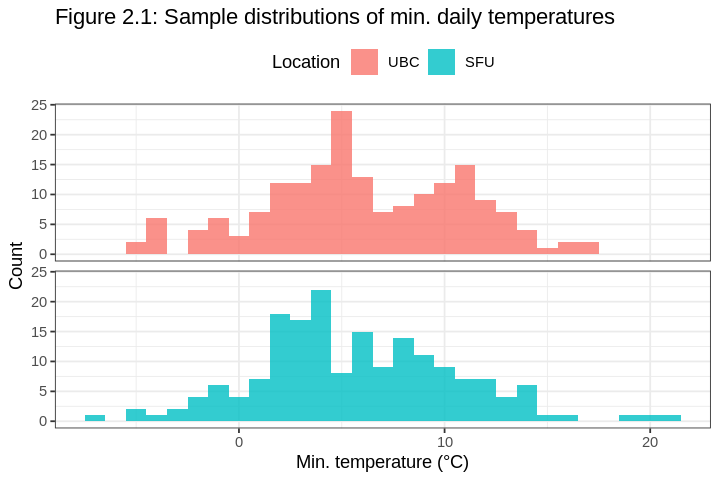

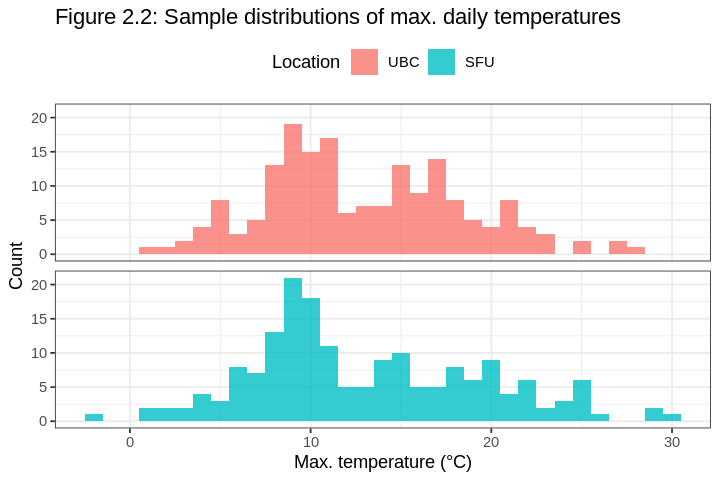

In [45]:
# Plot sample distributions for min. daily temperatures.
ubc_sfu_min_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2.1: Sample distributions of min. daily temperatures",
             x = "Min. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

# Plot sample distributions for max. daily temperatures.
ubc_sfu_max_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2.2: Sample distributions of max. daily temperatures",
             x = "Max. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

ubc_sfu_min_sample_dist
ubc_sfu_max_sample_dist

To get a better idea of the centers and spreads of the sample distributions, we can compare boxplots. We see that both sample distributions for min. and max. daily temperatures (especially SFU's max. temperatures) are slightly right-skewed.

In particular, we observe that the boxplots of min. daily temperatures for both locations appear very similar, except that SFU's is offset slightly to the left compared to UBC's.

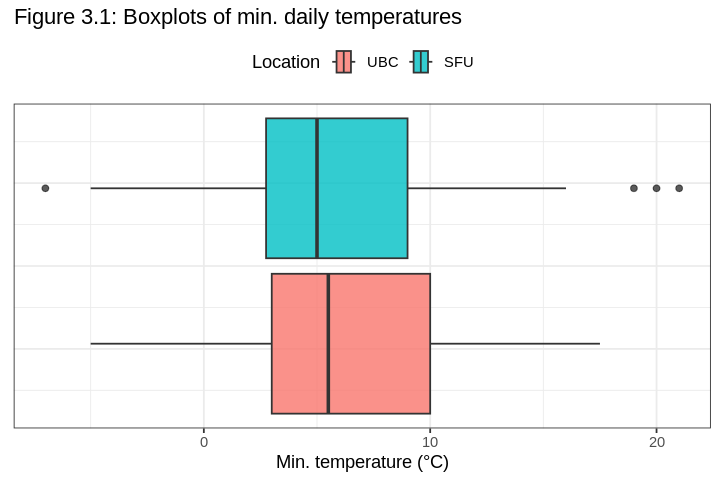

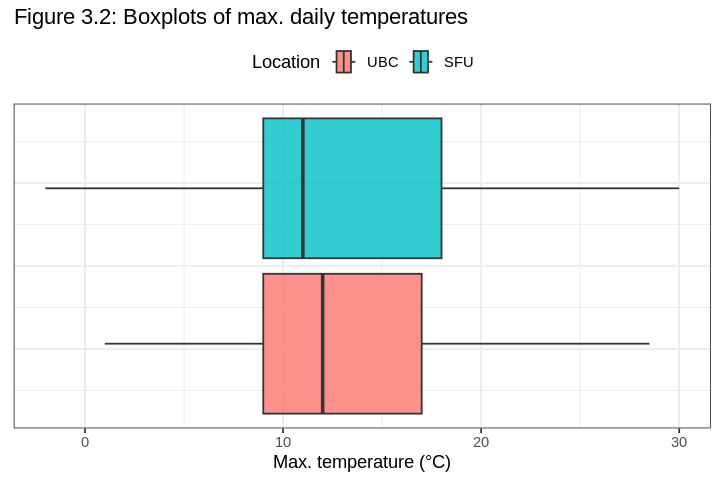

In [54]:
# Create boxplots for min. daily temperatures.
ubc_sfu_min_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 3.1: Boxplots of min. daily temperatures",
             x = "Min. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

# Create boxplots for max. daily temperatures.
ubc_sfu_max_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 3.2: Boxplots of max. daily temperatures",
             x = "Max. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

ubc_sfu_min_boxplot
ubc_sfu_max_boxplot